In [14]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import time

In [15]:
%config Completer.use_jedi = False

In [16]:


class Timer():
    """
    A small class to measure time during training.
    """
    def __init__(self):
        self._start_time = None

    def start(self):
        """
        Start a new timer
        """
        self._start_time = time.perf_counter()

    def stop(self):
        """
        Stop the timer, and report the elapsed time
        """
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
            return 0
    
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        
        return elapsed_time

In [17]:
data_models = ['GFDL-ESM4','IPSL-CM6A-LR','MPI-ESM1-2-HR']  # models for temp, prec, LAI
day_len = 90  # for gen_data_card()

dmodel = 'IPSL-CM6A-LR' #np.random.choice(np.array(data_models))  # choose a model
# load all data externally to save computationtime

temp_ds = np.array(xr.open_mfdataset('data/near_surface_air_temperature/historical/{}/*.nc'.format(dmodel)).tas)
prec_ds = np.array(xr.open_mfdataset('data/precipitation_flux/historical/{}/*.nc'.format(dmodel)).pr)
npp_files = glob.glob('data/net_primary_production_on_land/historical/**/*.nc', recursive=True) 
npp_ds = np.array(xr.open_mfdataset(np.random.choice(np.array(npp_files))).npp)
lai_ds = xr.open_mfdataset('data/leaf_area_index/historical/{}/*.nc'.format(dmodel))


# Normalize inputs
temp_ds = (temp_ds - np.mean(temp_ds)) / np.std(temp_ds)
prec_ds = (prec_ds - np.mean(prec_ds)) / np.std(prec_ds)

max_month = 1978
min_month = day_len//28

def gen_data_card():
    while True:
        
        output_month_i = np.random.randint(min_month, max_month)  # y_pred timepoint in int
        
        try:
            endstamp = lai_ds.indexes['time'].to_datetimeindex()[output_month_i]  # cfttimeindex to datetime
        except:
            endstamp = lai_ds.indexes['time'][output_month_i]
        output_day_i = (endstamp - pd.Timestamp('1850-01-01T12')).days  # output is i-th day in int

        # continue with month-based metrics
        lai = np.array(lai_ds.lai)[output_month_i]

        npp = npp_ds[output_month_i]


        # day-based metrics
        temp = temp_ds[output_day_i-day_len:output_day_i]

        prec = prec_ds[output_day_i-day_len:output_day_i]


        inputs = np.stack((temp,prec), axis=-1)  # two features

        outputs = np.stack((lai,npp), axis=-1)
        
        outputs = np.nan_to_num(outputs)


        yield (inputs, outputs)

In [18]:
"""batch_size = 32
models = ['GFDL-ESM4','IPSL-CM6A-LR','MPI-ESM1-2-HR']  # models for temp, prec, LAI
day_len = 10  # for gen_data_card()

MODEL = 'MPI-ESM1-2-HR'#np.random.choice(np.array(models))
temp_ds = np.array(xr.open_mfdataset('data/near_surface_air_temperature/historical/{}/*.nc'.format(MODEL)).tas)


prec_ds = np.array(xr.open_mfdataset('data/precipitation_flux/historical/{}/*.nc'.format(MODEL)).pr)

# Normalize inputs
temp_ds = (temp_ds - np.mean(temp_ds)) / np.std(temp_ds)
prec_ds = (prec_ds - np.mean(prec_ds)) / np.std(prec_ds)



max_month = 1978

min_month = day_len//32


def gen_data_card():
    while True:
        
        output_month_i = np.random.randint(min_month, max_month)  # y_pred timepoint in int

        # month-based metrics
        
        lai = xr.open_mfdataset('data/leaf_area_index/historical/{}/*.nc'.format(MODEL))

        # compute day index
        try:
            endstamp = lai.indexes['time'].to_datetimeindex()[output_month_i]  # cfttimeindex to datetime
        except:
            endstamp = lai.indexes['time'][output_month_i]
        output_day_i = (endstamp - pd.Timestamp('1850-01-01T12')).days  # output is i-th day in int

        # continue with month-based metrics
        lai = np.array(lai.lai)[output_month_i]
        npp_files = glob.glob('data/net_primary_production_on_land/historical/**/*.nc', recursive=True) 
        npp = xr.open_mfdataset(np.random.choice(np.array(npp_files)))
        npp = np.array(npp.npp)[output_month_i]

        # day-based metrics
        temp = temp_ds[output_day_i-day_len:output_day_i]
        prec = prec_ds[output_day_i-day_len:output_day_i]

        inputs = np.stack((temp,prec), axis=-1)  # two features
        outputs = np.stack((lai,npp), axis=-1)
        outputs = np.nan_to_num(outputs)

        yield (inputs, outputs)"""

"batch_size = 32\nmodels = ['GFDL-ESM4','IPSL-CM6A-LR','MPI-ESM1-2-HR']  # models for temp, prec, LAI\nday_len = 10  # for gen_data_card()\n\nMODEL = 'MPI-ESM1-2-HR'#np.random.choice(np.array(models))\ntemp_ds = np.array(xr.open_mfdataset('data/near_surface_air_temperature/historical/{}/*.nc'.format(MODEL)).tas)\n\n\nprec_ds = np.array(xr.open_mfdataset('data/precipitation_flux/historical/{}/*.nc'.format(MODEL)).pr)\n\n# Normalize inputs\ntemp_ds = (temp_ds - np.mean(temp_ds)) / np.std(temp_ds)\nprec_ds = (prec_ds - np.mean(prec_ds)) / np.std(prec_ds)\n\n\n\nmax_month = 1978\n\nmin_month = day_len//32\n\n\ndef gen_data_card():\n    while True:\n        \n        output_month_i = np.random.randint(min_month, max_month)  # y_pred timepoint in int\n\n        # month-based metrics\n        \n        lai = xr.open_mfdataset('data/leaf_area_index/historical/{}/*.nc'.format(MODEL))\n\n        # compute day index\n        try:\n            endstamp = lai.indexes['time'].to_datetimeindex()[outp

In [19]:
BATCH_SIZE = 16

ds = tf.data.Dataset.from_generator(gen_data_card,output_types = (tf.float32,tf.float32))
train_ds = ds.batch(BATCH_SIZE).take(30).prefetch(tf.data.experimental.AUTOTUNE)

val_ds = ds.batch(BATCH_SIZE).take(30).prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
a = []
for i in train_ds.take(100):
    print(i[0][0])

tf.Tensor(
[[[[-2.30743    -0.22901112]
   [-2.264793   -0.22776315]
   [-2.2481806  -0.3034808 ]
   ...
   [-2.4756892  -0.3362857 ]
   [-2.3861861  -0.32744873]
   [-2.332381   -0.27174187]]

  [[-2.1217713  -0.39016524]
   [-2.005392   -0.39016524]
   [-1.8498062  -0.39016524]
   ...
   [-2.07759    -0.31392592]
   [-2.2702572  -0.3434422 ]
   [-2.2187166  -0.35398555]]

  [[-1.72915    -0.17866768]
   [-1.5645605  -0.0176156 ]
   [-1.3461967   0.21110316]
   ...
   [-1.6265994  -0.39016524]
   [-2.0093791  -0.39016524]
   [-1.987055   -0.36836135]]

  ...

  [[-0.42704645 -0.31421134]
   [-0.4047573  -0.25918472]
   [-0.36205477 -0.2558307 ]
   ...
   [-0.40341312 -0.33796847]
   [-0.36733449 -0.35149792]
   [-0.40638083 -0.3453585 ]]

  [[-0.72867656 -0.39016524]
   [-0.72427773 -0.38536242]
   [-0.7134033  -0.39016524]
   ...
   [-0.6749014  -0.39016524]
   [-0.7273723  -0.39016524]
   [-0.7316542  -0.39016524]]

  [[-0.8230688  -0.39016524]
   [-0.8259025  -0.39016524]
   [-0.81

tf.Tensor(
[[[[-2.5852327  -0.39016524]
   [-2.5390801  -0.3804973 ]
   [-2.5172513  -0.39016524]
   ...
   [-2.725688   -0.39016524]
   [-2.675406   -0.39016524]
   [-2.6368058  -0.39016524]]

  [[-2.1287766  -0.39016524]
   [-2.098056   -0.39016524]
   [-2.008744   -0.39016524]
   ...
   [-2.019496   -0.39016524]
   [-2.0996275  -0.39016524]
   [-2.2035003  -0.39016524]]

  [[-1.5418502  -0.3771322 ]
   [-1.4521625  -0.39016524]
   [-1.4413921  -0.35633337]
   ...
   [-1.5141844  -0.39016524]
   [-1.8801782  -0.39016524]
   [-1.752983   -0.37754357]]

  ...

  [[-1.1808374  -0.39016524]
   [-1.1300057  -0.34823906]
   [-1.0404307  -0.29271787]
   ...
   [-1.0823128  -0.39016524]
   [-1.1120961  -0.39016524]
   [-1.1466389  -0.39016524]]

  [[-0.778251   -0.3059167 ]
   [-0.8138806  -0.3358706 ]
   [-0.8282901  -0.3635416 ]
   ...
   [-0.71217173 -0.35232624]
   [-0.73098004 -0.32918078]
   [-0.74735945 -0.3179005 ]]

  [[-1.0238196  -0.39016524]
   [-1.0578015  -0.39016524]
   [-1.07

tf.Tensor(
[[[[-1.7714542  -0.39016524]
   [-1.7216887  -0.39016524]
   [-1.7126659  -0.39016524]
   ...
   [-1.8507627  -0.37289935]
   [-1.8398811  -0.39016524]
   [-1.808475   -0.39016524]]

  [[-1.1538243  -0.39016524]
   [-1.1225573  -0.39016524]
   [-1.1561599  -0.39016524]
   ...
   [-1.3864331  -0.39016524]
   [-1.3086883  -0.39016524]
   [-1.2395587  -0.39016524]]

  [[-0.6133236  -0.37723476]
   [-0.52541846  0.2754212 ]
   [-0.46581626  2.205548  ]
   ...
   [-0.8199899  -0.39016524]
   [-0.8998187  -0.36022896]
   [-0.8130168  -0.34932017]]

  ...

  [[-1.269379   -0.39016524]
   [-1.2934592  -0.39016524]
   [-1.2810866  -0.39016524]
   ...
   [-1.2379978  -0.39016524]
   [-1.2622341  -0.39016524]
   [-1.2296377  -0.39016524]]

  [[-1.6649003  -0.2210301 ]
   [-1.622319   -0.21360908]
   [-1.6510568  -0.28279567]
   ...
   [-1.6895528  -0.2114215 ]
   [-1.6749209  -0.20844562]
   [-1.6648775  -0.19841531]]

  [[-1.903974   -0.39016524]
   [-1.906033   -0.38436526]
   [-1.88

tf.Tensor(
[[[[-1.3027885  -0.39016524]
   [-1.3136487  -0.39016524]
   [-1.2448142  -0.39016524]
   ...
   [-1.2838035  -0.39016524]
   [-1.2896633  -0.36964738]
   [-1.2801181  -0.39016524]]

  [[-0.27505472 -0.39016524]
   [-0.30165577 -0.39016524]
   [-0.3194549  -0.39016524]
   ...
   [-0.49120426 -0.38424045]
   [-0.39259994 -0.3763863 ]
   [-0.33801663 -0.34325483]]

  [[-0.31875786 -0.27020842]
   [-0.3014448  -0.1548838 ]
   [-0.27834457 -0.21514678]
   ...
   [-0.3608104  -0.24480005]
   [-0.38702658  0.5836349 ]
   [-0.3571485  -0.19024317]]

  ...

  [[-1.460313   -0.33945155]
   [-1.4649606  -0.32795733]
   [-1.4748002  -0.31050494]
   ...
   [-1.6713147  -0.39016524]
   [-1.5820254  -0.36535725]
   [-1.5034132  -0.34553903]]

  [[-1.4359242  -0.2850438 ]
   [-1.4664694  -0.3055515 ]
   [-1.5049348  -0.3562687 ]
   ...
   [-1.5220754  -0.32464913]
   [-1.454622   -0.29754007]
   [-1.4336877  -0.28254887]]

  [[-1.3076007  -0.17387258]
   [-1.2600483  -0.17983013]
   [-1.24

tf.Tensor(
[[[[-2.3074293e+00 -3.9016524e-01]
   [-2.2305288e+00 -3.9016524e-01]
   [-2.2310092e+00 -3.9016524e-01]
   ...
   [-2.2970421e+00 -3.9016524e-01]
   [-2.3011689e+00 -3.9016524e-01]
   [-2.3280714e+00 -3.9016524e-01]]

  [[-2.0789599e+00 -3.9016524e-01]
   [-2.1033714e+00 -3.9016524e-01]
   [-2.1742401e+00 -3.9016524e-01]
   ...
   [-2.0656893e+00 -3.9016524e-01]
   [-2.1584258e+00 -3.9016524e-01]
   [-2.0927784e+00 -3.9016524e-01]]

  [[-1.4360510e+00 -9.3042403e-02]
   [-1.3581558e+00 -1.2313892e-01]
   [-1.3401657e+00 -1.1550271e-01]
   ...
   [-1.6118429e+00 -3.9016524e-01]
   [-1.8468421e+00 -3.7277293e-01]
   [-1.7061696e+00 -2.5166747e-01]]

  ...

  [[-1.4431304e-01  1.9549270e+00]
   [-1.5833624e-01 -3.8467279e-01]
   [-2.0143929e-01 -3.7429741e-01]
   ...
   [-2.0961973e-01 -3.0795637e-01]
   [-1.9903462e-01 -3.9016524e-01]
   [-1.7810529e-01  3.2994442e+00]]

  [[-1.6238727e-01  1.5744595e-01]
   [-1.5822649e-01 -7.9136364e-02]
   [-1.4562014e-01 -2.9150432e-01]
 

tf.Tensor(
[[[[-2.47023273e+00 -3.90165240e-01]
   [-2.41429377e+00 -3.90165240e-01]
   [-2.36980748e+00 -3.90165240e-01]
   ...
   [-2.56726480e+00 -3.90165240e-01]
   [-2.48150778e+00 -3.90165240e-01]
   [-2.49316192e+00 -3.90165240e-01]]

  [[-1.61015880e+00 -3.90165240e-01]
   [-1.85110056e+00 -3.90165240e-01]
   [-2.03427958e+00 -3.90165240e-01]
   ...
   [-1.66753662e+00 -3.64231825e-01]
   [-1.52808785e+00 -3.90165240e-01]
   [-1.52930081e+00 -3.90165240e-01]]

  [[-1.33274353e+00 -3.11219573e-01]
   [-1.43980348e+00 -3.33466232e-01]
   [-1.58693457e+00 -3.44734102e-01]
   ...
   [-1.35253751e+00 -3.90165240e-01]
   [-1.60189283e+00 -3.90165240e-01]
   [-1.52493620e+00 -3.90165240e-01]]

  ...

  [[-2.10715875e-01 -7.40810633e-02]
   [-1.89387426e-01 -8.83133262e-02]
   [-2.21511945e-01 -3.30750823e-01]
   ...
   [-2.69995928e-01 -2.83136636e-01]
   [-2.80124903e-01 -3.25487256e-01]
   [-2.60934591e-01 -5.79728261e-02]]

  [[-2.74907917e-01  1.06938511e-01]
   [-2.83950716e-01  

tf.Tensor(
[[[[-1.8392596  -0.37839347]
   [-1.8218732  -0.39016524]
   [-1.7758523  -0.39016524]
   ...
   [-1.8728303  -0.39016524]
   [-1.8629478  -0.39016524]
   [-1.8263568  -0.39016524]]

  [[-1.1585588  -0.39016524]
   [-1.1810755  -0.39016524]
   [-1.2038078  -0.39016524]
   ...
   [-1.1656724  -0.39016524]
   [-1.1192367  -0.39016524]
   [-1.1358948  -0.39016524]]

  [[-0.76036775 -0.1938107 ]
   [-0.8247223  -0.29867998]
   [-0.8966543  -0.3568239 ]
   ...
   [-0.84098625 -0.39016524]
   [-0.9421107  -0.39016524]
   [-0.8396877  -0.32262915]]

  ...

  [[-1.3398037  -0.37400523]
   [-1.3058923  -0.36468786]
   [-1.3222097  -0.3755361 ]
   ...
   [-1.4935422  -0.39016524]
   [-1.4819828  -0.39016524]
   [-1.4241439  -0.39016524]]

  [[-1.5737695  -0.39016524]
   [-1.5504689  -0.38567463]
   [-1.5819747  -0.39016524]
   ...
   [-1.6589079  -0.39016524]
   [-1.6471097  -0.39016524]
   [-1.5926234  -0.39016524]]

  [[-1.3640392  -0.28906864]
   [-1.3382365  -0.26379266]
   [-1.33

tf.Tensor(
[[[[-1.81708300e+00 -3.55319530e-01]
   [-1.77761912e+00 -3.84191006e-01]
   [-1.73388314e+00 -3.84250373e-01]
   ...
   [-1.87176335e+00 -3.58268827e-01]
   [-1.86254513e+00 -3.90165240e-01]
   [-1.84806442e+00 -3.90165240e-01]]

  [[-8.32314014e-01 -3.13501209e-01]
   [-8.28257322e-01 -3.76815826e-01]
   [-8.14554811e-01 -3.62417698e-01]
   ...
   [-1.06843936e+00 -2.41177902e-01]
   [-9.53023672e-01 -2.03814879e-01]
   [-8.82186353e-01 -3.10301989e-01]]

  [[-8.95087779e-01 -1.61232706e-02]
   [-6.93011343e-01  3.79978776e-01]
   [-6.04929388e-01  3.48551050e-02]
   ...
   [-9.59539235e-01 -3.90165240e-01]
   [-1.15830803e+00 -3.90165240e-01]
   [-1.08263779e+00 -3.14989626e-01]]

  ...

  [[-1.53443515e+00 -3.90165240e-01]
   [-1.49304402e+00 -3.90165240e-01]
   [-1.49091876e+00 -3.90165240e-01]
   ...
   [-1.60794294e+00 -3.90165240e-01]
   [-1.57875478e+00 -3.90165240e-01]
   [-1.56118727e+00 -3.90165240e-01]]

  [[-1.47590268e+00 -3.90165240e-01]
   [-1.44438612e+00 -

tf.Tensor(
[[[[-1.35648668e+00 -3.90165240e-01]
   [-1.35017276e+00 -3.90165240e-01]
   [-1.32976592e+00 -3.90165240e-01]
   ...
   [-1.38558292e+00 -3.90165240e-01]
   [-1.38073647e+00 -3.90165240e-01]
   [-1.35950136e+00 -3.90165240e-01]]

  [[-3.12106878e-01 -2.80607760e-01]
   [-3.48129928e-01 -3.90165240e-01]
   [-3.65779370e-01 -3.90165240e-01]
   ...
   [-4.38844591e-01  9.45006847e-01]
   [-3.17573339e-01  4.72545505e-01]
   [-2.75011957e-01 -6.94310814e-02]]

  [[-2.93309987e-01  6.60661340e-01]
   [-2.98216254e-01  3.33449364e-01]
   [-3.09073627e-01 -1.59593627e-01]
   ...
   [-3.25783730e-01 -4.00920361e-02]
   [-3.69667888e-01 -2.47469813e-01]
   [-3.28211188e-01  9.70868617e-02]]

  ...

  [[-1.46122813e+00 -3.41970563e-01]
   [-1.32428157e+00 -3.27657729e-01]
   [-1.26238310e+00 -3.37237269e-01]
   ...
   [-1.69028187e+00 -3.90165240e-01]
   [-1.61953223e+00 -3.90165240e-01]
   [-1.52958095e+00 -3.57108414e-01]]

  [[-1.38117766e+00 -3.27599972e-01]
   [-1.26482332e+00 -

tf.Tensor(
[[[[-1.898447   -0.39016524]
   [-1.855349   -0.39016524]
   [-1.8659327  -0.39016524]
   ...
   [-2.0416396  -0.39016524]
   [-2.0159018  -0.39016524]
   [-1.9824109  -0.39016524]]

  [[-0.7568997  -0.16762267]
   [-0.7216564  -0.02783165]
   [-0.70993954 -0.03305473]
   ...
   [-0.87159127 -0.39016524]
   [-0.83698654 -0.39016524]
   [-0.77934283 -0.39016524]]

  [[-0.4168847  -0.27282792]
   [-0.4028729  -0.22786577]
   [-0.34355006 -0.00377554]
   ...
   [-0.560763   -0.29932472]
   [-0.60640895  0.21728179]
   [-0.51277363 -0.12219506]]

  ...

  [[-1.490144   -0.33870846]
   [-1.4668806  -0.33534753]
   [-1.4594721  -0.32655197]
   ...
   [-1.4902074  -0.3301301 ]
   [-1.4932436  -0.34180152]
   [-1.5011176  -0.34235567]]

  [[-1.6056459  -0.3476216 ]
   [-1.6220388  -0.35067466]
   [-1.6119776  -0.34545887]
   ...
   [-1.5817304  -0.33809355]
   [-1.5922685  -0.34608057]
   [-1.6169993  -0.34700224]]

  [[-1.4005975  -0.39016524]
   [-1.4165293  -0.36853105]
   [-1.42

tf.Tensor(
[[[[-1.9614495  -0.39016524]
   [-1.9356545  -0.39016524]
   [-1.910635   -0.39016524]
   ...
   [-2.001111   -0.39016524]
   [-2.0003662  -0.39016524]
   [-1.9704689  -0.39016524]]

  [[-0.8797389  -0.30360156]
   [-0.8671283  -0.3498814 ]
   [-0.903502   -0.39016524]
   ...
   [-1.1909164  -0.39016524]
   [-1.1240418  -0.39016524]
   [-1.0146599  -0.39016524]]

  [[-0.570671   -0.02664861]
   [-0.66108775 -0.373854  ]
   [-0.6445858  -0.3678284 ]
   ...
   [-0.83734286 -0.39016524]
   [-0.8812941  -0.31294096]
   [-0.6827854   0.2162584 ]]

  ...

  [[-1.2472224  -0.28068346]
   [-1.2826176  -0.31360325]
   [-1.306804   -0.33396417]
   ...
   [-1.0596858  -0.12118398]
   [-1.1476196  -0.23856965]
   [-1.1835101  -0.24815561]]

  [[-1.099633   -0.2685734 ]
   [-1.1587     -0.29694757]
   [-1.1980442  -0.26109117]
   ...
   [-0.95729846 -0.3395592 ]
   [-1.0105206  -0.32768846]
   [-1.0436699  -0.30492523]]

  [[-1.3474139  -0.3677826 ]
   [-1.351415   -0.3644356 ]
   [-1.36

tf.Tensor(
[[[[-2.2645242  -0.2871548 ]
   [-2.3327425  -0.28218886]
   [-2.3995123  -0.35706124]
   ...
   [-2.4927557  -0.28431857]
   [-2.2777016  -0.2226617 ]
   [-2.1869056  -0.2446661 ]]

  [[-0.7595596   1.25787   ]
   [-0.7356197   0.87114924]
   [-0.788303    1.144756  ]
   ...
   [-1.0786253   3.0385027 ]
   [-0.81793445  2.2298663 ]
   [-0.7563253   1.550666  ]]

  [[-0.69935584 -0.06529734]
   [-0.65816283 -0.1207751 ]
   [-0.72060305 -0.16277865]
   ...
   [-0.70647293  0.9301066 ]
   [-0.730551    0.6017185 ]
   [-0.83365965  0.06725699]]

  ...

  [[-0.2636101  -0.28600618]
   [-0.26569402 -0.2859828 ]
   [-0.24969949 -0.2783216 ]
   ...
   [-0.28789768 -0.32368335]
   [-0.27398708 -0.28682524]
   [-0.26368847 -0.26593694]]

  [[-0.22450817 -0.32916707]
   [-0.21567774 -0.32947916]
   [-0.21155545 -0.3367361 ]
   ...
   [-0.2533856  -0.30222797]
   [-0.24251683 -0.30310485]
   [-0.23285824 -0.32327887]]

  [[-0.23055191 -0.35278213]
   [-0.22874022 -0.34261006]
   [-0.22

tf.Tensor(
[[[[-2.5256457  -0.39016524]
   [-2.5252266  -0.39016524]
   [-2.4335127  -0.39016524]
   ...
   [-2.685413   -0.39016524]
   [-2.6667008  -0.39016524]
   [-2.594533   -0.39016524]]

  [[-2.2722087  -0.39016524]
   [-2.1655664  -0.39016524]
   [-2.0860927  -0.39016524]
   ...
   [-2.0060115  -0.39016524]
   [-2.2398098  -0.39016524]
   [-2.2554352  -0.39016524]]

  [[-1.2801801  -0.10802969]
   [-1.2815727   0.1273282 ]
   [-1.2889199   0.4172709 ]
   ...
   [-1.3953149  -0.39016524]
   [-1.5290257  -0.39016524]
   [-1.478187   -0.28388244]]

  ...

  [[-0.74471956 -0.39016524]
   [-0.96074796 -0.39016524]
   [-1.0391207  -0.39016524]
   ...
   [-0.58399576 -0.39016524]
   [-0.5399263  -0.09627093]
   [-0.6266099  -0.3480711 ]]

  [[-0.95043224 -0.31837633]
   [-0.9863028  -0.36529398]
   [-1.006746   -0.39016524]
   ...
   [-0.9278252  -0.36118725]
   [-0.8988751  -0.3379876 ]
   [-0.95071447 -0.30024216]]

  [[-0.89906037 -0.39016524]
   [-0.8975765  -0.39016524]
   [-0.89

tf.Tensor(
[[[[-1.5809891  -0.39016524]
   [-1.5715088  -0.39016524]
   [-1.543245   -0.39016524]
   ...
   [-1.6493006  -0.39016524]
   [-1.6051021  -0.39016524]
   [-1.6075488  -0.39016524]]

  [[-0.8263202  -0.39016524]
   [-0.80867213 -0.39016524]
   [-0.7920775  -0.39016524]
   ...
   [-0.9862229  -0.39016524]
   [-0.86979526 -0.39016524]
   [-0.86313003 -0.39016524]]

  [[-0.47733927 -0.35690477]
   [-0.516283   -0.35613674]
   [-0.54452896 -0.33360612]
   ...
   [-0.5894266  -0.39016524]
   [-0.63099587 -0.39016524]
   [-0.5087682  -0.36498836]]

  ...

  [[-1.7641732  -0.39016524]
   [-1.8104029  -0.39016524]
   [-1.8377302  -0.39016524]
   ...
   [-1.6608065  -0.39016524]
   [-1.7254504  -0.39016524]
   [-1.7621305  -0.39016524]]

  [[-1.5617154  -0.31965792]
   [-1.566611   -0.28138494]
   [-1.5647694  -0.3066876 ]
   ...
   [-1.5423647  -0.32200494]
   [-1.5540638  -0.29324478]
   [-1.5490898  -0.31956777]]

  [[-0.9949878  -0.01595346]
   [-1.0386873  -0.05346689]
   [-1.02

tf.Tensor(
[[[[-2.6435158e+00 -3.9016524e-01]
   [-2.6813178e+00 -3.9016524e-01]
   [-2.6368036e+00 -3.9016524e-01]
   ...
   [-2.7807097e+00 -3.9016524e-01]
   [-2.7426476e+00 -3.9016524e-01]
   [-2.7196841e+00 -3.9016524e-01]]

  [[-1.6774126e+00 -3.9016524e-01]
   [-1.6153700e+00 -3.9016524e-01]
   [-1.7154832e+00 -3.9016524e-01]
   ...
   [-1.8161787e+00 -3.9016524e-01]
   [-1.8384157e+00 -3.8014960e-01]
   [-1.7959100e+00 -3.9016524e-01]]

  [[-1.3531398e+00 -1.4831452e-01]
   [-1.3206539e+00 -2.1371372e-01]
   [-1.1756688e+00 -1.8219227e-01]
   ...
   [-1.2378424e+00 -3.1412053e-01]
   [-1.6141413e+00 -3.3550820e-01]
   [-1.5404996e+00 -2.8594488e-01]]

  ...

  [[-1.7760925e-01 -2.7035722e-01]
   [-1.7488101e-01 -2.7137649e-01]
   [-1.7501928e-01 -3.0613840e-01]
   ...
   [-1.8113571e-01 -2.2532210e-01]
   [-1.7948081e-01 -3.3583027e-01]
   [-1.7987850e-01 -3.0156472e-01]]

  [[-1.8513827e-01 -3.4553930e-01]
   [-1.8183559e-01 -3.5605931e-01]
   [-1.8188120e-01 -3.5977018e-01]
 

tf.Tensor(
[[[[-2.5025647  -0.39016524]
   [-2.4425962  -0.39016524]
   [-2.4012299  -0.39016524]
   ...
   [-2.501797   -0.39016524]
   [-2.4764903  -0.39016524]
   [-2.4399834  -0.39016524]]

  [[-1.4445122  -0.3063442 ]
   [-1.5017974  -0.32651657]
   [-1.5419457  -0.3339615 ]
   ...
   [-1.5969772  -0.27021298]
   [-1.4403366  -0.23955424]
   [-1.4367068  -0.24274395]]

  [[-1.3164154  -0.3486684 ]
   [-1.2476557  -0.3151136 ]
   [-1.2200198  -0.23778601]
   ...
   [-1.3313375  -0.39016524]
   [-1.6446366  -0.39016524]
   [-1.5390742  -0.34910992]]

  ...

  [[-0.21178067 -0.18748711]
   [-0.20456807 -0.11209808]
   [-0.22362868 -0.35766447]
   ...
   [-0.22438559 -0.31832317]
   [-0.19489522 -0.33268213]
   [-0.19867115 -0.31372055]]

  [[-0.25010574 -0.3265059 ]
   [-0.26043853 -0.3347537 ]
   [-0.26058537 -0.33106306]
   ...
   [-0.22158465 -0.33739045]
   [-0.23490512 -0.32220754]
   [-0.23904026 -0.3337511 ]]

  [[-0.20360449 -0.11222848]
   [-0.20351897 -0.17627439]
   [-0.20

tf.Tensor(
[[[[-2.0247636  -0.39016524]
   [-1.9964527  -0.39016524]
   [-1.9638449  -0.39016524]
   ...
   [-2.1294322  -0.38507205]
   [-2.093016   -0.39016524]
   [-2.074035   -0.39016524]]

  [[-1.3019917  -0.39016524]
   [-1.3020886  -0.39016524]
   [-1.3226331  -0.39016524]
   ...
   [-1.2444079  -0.39016524]
   [-1.2461098  -0.38513222]
   [-1.2880226  -0.39016524]]

  [[-0.49360752 -0.2506768 ]
   [-0.48067188 -0.2627283 ]
   [-0.5213489  -0.32054743]
   ...
   [-0.7142129  -0.39016524]
   [-0.81064206 -0.39016524]
   [-0.6603266  -0.35056025]]

  ...

  [[-1.7319068  -0.39016524]
   [-1.7320044  -0.39016524]
   [-1.765873   -0.39016524]
   ...
   [-1.5943524  -0.3641034 ]
   [-1.6236218  -0.39016524]
   [-1.7032026  -0.39016524]]

  [[-1.4506829  -0.13517529]
   [-1.4783994  -0.14228834]
   [-1.5324738  -0.17890893]
   ...
   [-1.3942074  -0.24271023]
   [-1.3940121  -0.185923  ]
   [-1.4223279  -0.17481752]]

  [[-1.4289967  -0.25397304]
   [-1.4069449  -0.24424678]
   [-1.41

tf.Tensor(
[[[[-2.3308046e+00 -3.8489103e-01]
   [-2.3953578e+00 -3.9016524e-01]
   [-2.3056824e+00 -3.9016524e-01]
   ...
   [-2.4983733e+00 -3.8466308e-01]
   [-2.4941819e+00 -3.9016524e-01]
   [-2.4023788e+00 -3.9016524e-01]]

  [[-1.5217868e+00 -3.9016524e-01]
   [-1.4912302e+00 -3.9016524e-01]
   [-1.5567735e+00 -3.9016524e-01]
   ...
   [-1.7314763e+00 -3.8493514e-01]
   [-1.6770691e+00 -3.9016524e-01]
   [-1.5774691e+00 -3.9016524e-01]]

  [[-1.4954231e+00 -3.2715806e-01]
   [-1.5742655e+00 -3.4463984e-01]
   [-1.6592137e+00 -3.6249864e-01]
   ...
   [-1.3037400e+00 -3.9016524e-01]
   [-1.5054901e+00 -3.9016524e-01]
   [-1.5976728e+00 -3.5660771e-01]]

  ...

  [[-4.8781464e-01 -2.6487452e-01]
   [-4.6562952e-01 -2.3627427e-01]
   [-5.0451189e-01 -2.7231428e-01]
   ...
   [-5.9305286e-01 -3.4525156e-01]
   [-5.5126548e-01 -3.1439638e-01]
   [-5.1227754e-01 -2.9957783e-01]]

  [[-6.1073083e-01 -3.5183397e-01]
   [-5.8557940e-01 -3.4105459e-01]
   [-5.6444341e-01 -3.2950485e-01]
 

tf.Tensor(
[[[[-2.295369   -0.39016524]
   [-2.2847195  -0.39016524]
   [-2.2772675  -0.39016524]
   ...
   [-2.4391973  -0.39016524]
   [-2.4160593  -0.39016524]
   [-2.3634293  -0.39016524]]

  [[-2.3284307  -0.39016524]
   [-2.213764   -0.39016524]
   [-2.136198   -0.39016524]
   ...
   [-1.9435072  -0.39016524]
   [-2.1965399  -0.39016524]
   [-2.2564836  -0.39016524]]

  [[-1.468497   -0.35328463]
   [-1.3645352  -0.30551353]
   [-1.2661582  -0.23603627]
   ...
   [-1.4459085  -0.39016524]
   [-1.7699432  -0.39016524]
   [-1.6758119  -0.39016524]]

  ...

  [[-0.19771755 -0.19866171]
   [-0.19797412 -0.31350112]
   [-0.19907168 -0.30031064]
   ...
   [-0.21158965 -0.3572526 ]
   [-0.20541191 -0.3524726 ]
   [-0.20462508 -0.31970164]]

  [[-0.19379908 -0.24189162]
   [-0.19720581 -0.22791477]
   [-0.19905172 -0.24064593]
   ...
   [-0.18963687 -0.31678873]
   [-0.18851508 -0.27496275]
   [-0.18969531 -0.27163076]]

  [[-0.22940731 -0.27169624]
   [-0.22680308 -0.2739729 ]
   [-0.22

tf.Tensor(
[[[[-1.4816208  -0.39016524]
   [-1.4611241  -0.39016524]
   [-1.4198755  -0.37980613]
   ...
   [-1.5344629  -0.39016524]
   [-1.5360345  -0.39016524]
   [-1.5074514  -0.39016524]]

  [[-0.5120167  -0.39016524]
   [-0.5401159  -0.39016524]
   [-0.5765622  -0.39016524]
   ...
   [-0.57742465 -0.39016524]
   [-0.49731502 -0.39016524]
   [-0.4957257  -0.39016524]]

  [[-0.42880255 -0.22905827]
   [-0.397204   -0.1260845 ]
   [-0.39149383 -0.20043866]
   ...
   [-0.4090036  -0.20668519]
   [-0.50009316 -0.34867015]
   [-0.5019918  -0.33244428]]

  ...

  [[-1.954326   -0.39016524]
   [-1.9573095  -0.39016524]
   [-1.9253424  -0.39016524]
   ...
   [-1.9414688  -0.39016524]
   [-1.9527667  -0.39016524]
   [-1.9619584  -0.39016524]]

  [[-1.6723139  -0.39016524]
   [-1.6374184  -0.39016524]
   [-1.614894   -0.39016524]
   ...
   [-1.7635958  -0.39016524]
   [-1.7295114  -0.39016524]
   [-1.7172849  -0.39016524]]

  [[-1.460194   -0.3852864 ]
   [-1.4634603  -0.39016524]
   [-1.45

tf.Tensor(
[[[[-2.30220437e+00 -3.90165240e-01]
   [-2.20551515e+00 -3.90165240e-01]
   [-2.13063097e+00 -3.90165240e-01]
   ...
   [-2.38584542e+00 -3.83813739e-01]
   [-2.29241967e+00 -3.90165240e-01]
   [-2.28150964e+00 -3.90165240e-01]]

  [[-1.92328763e+00 -3.90165240e-01]
   [-1.97455764e+00 -3.90165240e-01]
   [-2.06329536e+00 -3.90165240e-01]
   ...
   [-1.97413218e+00 -3.84521574e-01]
   [-1.97791946e+00 -3.90165240e-01]
   [-2.05054283e+00 -3.90165240e-01]]

  [[-1.40322590e+00 -3.30427051e-01]
   [-1.52490127e+00 -3.38764876e-01]
   [-1.69840252e+00 -3.34460557e-01]
   ...
   [-1.46649861e+00 -3.90165240e-01]
   [-1.66694725e+00 -3.90165240e-01]
   [-1.57648981e+00 -3.90165240e-01]]

  ...

  [[-3.33716154e-01 -3.45950007e-01]
   [-4.42643315e-01 -3.42260718e-01]
   [-5.41357398e-01 -3.44642967e-01]
   ...
   [-3.57483476e-01 -4.20108996e-02]
   [-3.24228615e-01  1.63465768e-01]
   [-3.14763874e-01 -5.79134151e-02]]

  [[-4.03723866e-01 -1.20090276e-01]
   [-4.10446107e-01 -

tf.Tensor(
[[[[-2.37047243e+00 -3.90165240e-01]
   [-2.36769557e+00 -3.90165240e-01]
   [-2.32691097e+00 -3.90165240e-01]
   ...
   [-2.51607966e+00 -3.90165240e-01]
   [-2.46874380e+00 -3.90165240e-01]
   [-2.34329057e+00 -3.85523677e-01]]

  [[-2.22200346e+00 -3.90165240e-01]
   [-2.23935509e+00 -3.90165240e-01]
   [-2.27075338e+00 -3.90165240e-01]
   ...
   [-2.07457733e+00 -3.84905607e-01]
   [-2.14111996e+00 -3.82420331e-01]
   [-2.22408962e+00 -3.90165240e-01]]

  [[-1.28389895e+00 -3.23226362e-01]
   [-1.30439854e+00 -3.70146543e-01]
   [-1.30069745e+00 -3.90165240e-01]
   ...
   [-1.55874836e+00 -3.90165240e-01]
   [-1.72655296e+00 -3.90165240e-01]
   [-1.48327708e+00 -3.36977452e-01]]

  ...

  [[-2.57653296e-01 -3.19428563e-01]
   [-3.00545365e-01 -3.90165240e-01]
   [-3.38742137e-01 -3.65721375e-01]
   ...
   [-2.52171159e-01 -2.75900662e-01]
   [-2.37036124e-01 -2.99916238e-01]
   [-2.37828642e-01 -2.92811155e-01]]

  [[-4.04733032e-01 -3.90165240e-01]
   [-4.45596784e-01 -

tf.Tensor(
[[[[-1.8591199  -0.39016524]
   [-1.8416586  -0.39016524]
   [-1.7865336  -0.39016524]
   ...
   [-1.9247673  -0.39016524]
   [-1.9043624  -0.39016524]
   [-1.8644153  -0.39016524]]

  [[-0.7833839  -0.39016524]
   [-0.78715414 -0.39016524]
   [-0.8712121  -0.39016524]
   ...
   [-0.89141023 -0.39016524]
   [-0.72842    -0.38555068]
   [-0.75558406 -0.39016524]]

  [[-0.49817595 -0.11180097]
   [-0.49495453 -0.3048949 ]
   [-0.47212797 -0.29302806]
   ...
   [-0.5171496  -0.39016524]
   [-0.5598379  -0.2077838 ]
   [-0.53445554 -0.11415147]]

  ...

  [[-0.6898783  -0.27136877]
   [-0.59394515 -0.2496901 ]
   [-0.5362359  -0.2750221 ]
   ...
   [-1.2019306  -0.3314845 ]
   [-1.0722374  -0.1236038 ]
   [-0.8165689  -0.19664487]]

  [[-0.9507288  -0.14325778]
   [-0.9012099  -0.13216211]
   [-0.8817744  -0.18424165]
   ...
   [-1.1486907   0.05944639]
   [-1.0821482   0.03835901]
   [-1.014908   -0.02152564]]

  [[-1.3483703  -0.09274336]
   [-1.3601364  -0.14481887]
   [-1.35

tf.Tensor(
[[[[-2.821895   -0.39016524]
   [-2.7418208  -0.39016524]
   [-2.6554096  -0.39016524]
   ...
   [-2.8619874  -0.39016524]
   [-2.8008592  -0.3853374 ]
   [-2.8181074  -0.38499707]]

  [[-2.1318896  -0.39016524]
   [-2.152491   -0.39016524]
   [-2.2135465  -0.39016524]
   ...
   [-2.07894    -0.39016524]
   [-2.1757867  -0.39016524]
   [-2.160345   -0.39016524]]

  [[-1.5897726  -0.2930253 ]
   [-1.6257998  -0.3109165 ]
   [-1.7008578  -0.30545864]
   ...
   [-1.5644187  -0.39016524]
   [-1.8096446  -0.39016524]
   [-1.7561017  -0.346703  ]]

  ...

  [[-0.18355891 -0.32947648]
   [-0.17600994 -0.29829505]
   [-0.18028189 -0.2959795 ]
   ...
   [-0.21337427 -0.3310231 ]
   [-0.20606048 -0.35620585]
   [-0.1982706  -0.35706422]]

  [[-0.18732913  0.4304381 ]
   [-0.18509693  0.08165871]
   [-0.18058978 -0.2801015 ]
   ...
   [-0.2010188  -0.19100279]
   [-0.19393592  0.04324862]
   [-0.19116634 -0.06233212]]

  [[-0.1866649  -0.31872305]
   [-0.18785226 -0.37354803]
   [-0.18

tf.Tensor(
[[[[-2.6973450e+00 -3.9016524e-01]
   [-2.5859869e+00 -3.9016524e-01]
   [-2.5373375e+00 -3.9016524e-01]
   ...
   [-2.7364113e+00 -3.7742621e-01]
   [-2.6974421e+00 -3.9016524e-01]
   [-2.7835982e+00 -3.9016524e-01]]

  [[-2.6836383e+00 -3.9016524e-01]
   [-2.6672311e+00 -3.9016524e-01]
   [-2.6886785e+00 -3.9016524e-01]
   ...
   [-2.5331626e+00 -3.9016524e-01]
   [-2.6275747e+00 -3.9016524e-01]
   [-2.7409606e+00 -3.9016524e-01]]

  [[-1.8395711e+00 -3.6689153e-01]
   [-1.8438793e+00 -3.6590818e-01]
   [-1.9577335e+00 -3.6644685e-01]
   ...
   [-2.0041370e+00 -3.9016524e-01]
   [-2.3877618e+00 -3.9016524e-01]
   [-2.0688508e+00 -3.9016524e-01]]

  ...

  [[-3.0956396e-01 -2.9759419e-01]
   [-3.4873003e-01 -3.1877303e-01]
   [-3.7043336e-01 -3.6615810e-01]
   ...
   [-3.2516509e-01 -2.7186170e-01]
   [-3.2008919e-01 -2.9361790e-01]
   [-3.0536327e-01 -2.8037375e-01]]

  [[-6.3701540e-01 -3.9016524e-01]
   [-6.9770378e-01 -3.9016524e-01]
   [-6.8149966e-01 -3.7885052e-01]
 

tf.Tensor(
[[[[-2.2817705  -0.39016524]
   [-2.197887   -0.39016524]
   [-2.1585734  -0.39016524]
   ...
   [-2.3682153  -0.39016524]
   [-2.4156878  -0.39016524]
   [-2.3595517  -0.39016524]]

  [[-1.7504094  -0.38554496]
   [-1.7196989  -0.39016524]
   [-1.7764175  -0.39016524]
   ...
   [-1.8326784  -0.39016524]
   [-1.8963118  -0.39016524]
   [-1.7827904  -0.39016524]]

  [[-1.1137133  -0.39016524]
   [-1.018036   -0.39016524]
   [-0.98508406 -0.37669733]
   ...
   [-1.2900646  -0.39016524]
   [-1.4617057  -0.39016524]
   [-1.3388308  -0.39016524]]

  ...

  [[-0.79313517 -0.35392836]
   [-0.8073408  -0.35871664]
   [-0.81267756 -0.3664887 ]
   ...
   [-0.90199107 -0.36066976]
   [-0.85286134 -0.35251123]
   [-0.8000384  -0.34990743]]

  [[-0.9661289  -0.29081345]
   [-0.9579271  -0.25635743]
   [-0.96907806 -0.16257928]
   ...
   [-1.0514156  -0.35983992]
   [-1.0351139  -0.3541693 ]
   [-0.98717654 -0.32908788]]

  [[-1.4664865  -0.39016524]
   [-1.4771621  -0.39016524]
   [-1.51

tf.Tensor(
[[[[-1.4845471  -0.39016524]
   [-1.4680252  -0.39016524]
   [-1.4425822  -0.39016524]
   ...
   [-1.517817   -0.39016524]
   [-1.5113997  -0.39016524]
   [-1.4886438  -0.39016524]]

  [[-0.5900039  -0.39016524]
   [-0.61923623 -0.39016524]
   [-0.6305868  -0.39016524]
   ...
   [-0.6919465  -0.39016524]
   [-0.5880653  -0.39016524]
   [-0.5824578  -0.39016524]]

  [[-0.33408675 -0.39016524]
   [-0.36159152 -0.39016524]
   [-0.34961236 -0.39016524]
   ...
   [-0.43619475 -0.39016524]
   [-0.41975975 -0.39016524]
   [-0.37077686 -0.39016524]]

  ...

  [[-1.5084385  -0.39016524]
   [-1.5022101  -0.39016524]
   [-1.4529756  -0.37843353]
   ...
   [-1.4230136  -0.35824445]
   [-1.454394   -0.37051246]
   [-1.4960659  -0.39016524]]

  [[-1.1392096  -0.39016524]
   [-1.1181006  -0.39016524]
   [-1.1064365  -0.37162492]
   ...
   [-1.1767015  -0.39016524]
   [-1.1748414  -0.39016524]
   [-1.1542435  -0.39016524]]

  [[-1.1080757  -0.30482194]
   [-1.150094   -0.34111786]
   [-1.19

tf.Tensor(
[[[[-1.657925   -0.39016524]
   [-1.6697767  -0.39016524]
   [-1.6736752  -0.39016524]
   ...
   [-1.656558   -0.28555122]
   [-1.5925114  -0.28195718]
   [-1.6649566  -0.2723164 ]]

  [[-0.4887426  -0.16693538]
   [-0.5854212  -0.35147187]
   [-0.6177795  -0.39016524]
   ...
   [-0.53522956  1.136012  ]
   [-0.44368955  0.40338826]
   [-0.4520368   0.1904144 ]]

  [[-0.30981767  0.47588214]
   [-0.31590134  0.37551352]
   [-0.31149966  0.24808542]
   ...
   [-0.3355806   0.8549105 ]
   [-0.41508153  0.58584476]
   [-0.32239267  0.01917884]]

  ...

  [[-1.5922441  -0.39016524]
   [-1.5469831  -0.39016524]
   [-1.4733491  -0.39016524]
   ...
   [-1.6363579  -0.39016524]
   [-1.645509   -0.39016524]
   [-1.6356566  -0.39016524]]

  [[-1.6298394  -0.39016524]
   [-1.6047593  -0.39016524]
   [-1.5814424  -0.39016524]
   ...
   [-1.6568097  -0.39016524]
   [-1.6703689  -0.39016524]
   [-1.6496441  -0.39016524]]

  [[-1.6551434  -0.39016524]
   [-1.6605599  -0.37360275]
   [-1.65

tf.Tensor(
[[[[-2.2719002  -0.39016524]
   [-2.2704997  -0.39016524]
   [-2.2096894  -0.39016524]
   ...
   [-2.4566748  -0.39016524]
   [-2.3985972  -0.39016524]
   [-2.369511   -0.39016524]]

  [[-1.0614071  -0.33440936]
   [-1.1758612  -0.34900364]
   [-1.2174177  -0.3514367 ]
   ...
   [-1.1959168  -0.39016524]
   [-0.98737466 -0.3772494 ]
   [-1.000534   -0.3307047 ]]

  [[-0.80193704 -0.26094642]
   [-0.78599954 -0.18005653]
   [-0.8730352  -0.19560705]
   ...
   [-0.79416573 -0.39016524]
   [-0.93490666 -0.39016524]
   [-0.9186185  -0.36374316]]

  ...

  [[-1.2238784  -0.39016524]
   [-1.2340295  -0.34995908]
   [-1.2913717  -0.33396283]
   ...
   [-1.2361982  -0.39016524]
   [-1.234373   -0.39016524]
   [-1.2465881  -0.39016524]]

  [[-1.5261927  -0.39016524]
   [-1.5583186  -0.39016524]
   [-1.5816911  -0.39016524]
   ...
   [-1.4849755  -0.39016524]
   [-1.4886737  -0.39016524]
   [-1.5032642  -0.39016524]]

  [[-1.4386588  -0.39016524]
   [-1.4097123  -0.39016524]
   [-1.41

tf.Tensor(
[[[[-2.4770062  -0.39016524]
   [-2.3669195  -0.39016524]
   [-2.3421857  -0.38361654]
   ...
   [-2.474      -0.39016524]
   [-2.4418278  -0.39016524]
   [-2.51016    -0.39016524]]

  [[-1.8667288  -0.39016524]
   [-1.8614897  -0.39016524]
   [-1.9414446  -0.39016524]
   ...
   [-1.9771497  -0.39016524]
   [-2.0107188  -0.39016524]
   [-1.9446418  -0.39016524]]

  [[-1.7202526  -0.24978875]
   [-1.7986239  -0.27666166]
   [-1.9543474  -0.3050348 ]
   ...
   [-1.6980312  -0.39016524]
   [-2.0292728  -0.39016524]
   [-1.9371612  -0.36721414]]

  ...

  [[-0.19646032 -0.2911333 ]
   [-0.1996846  -0.27920544]
   [-0.20248982 -0.25957468]
   ...
   [-0.23169224 -0.34206438]
   [-0.21103944 -0.32293925]
   [-0.20535347 -0.3066052 ]]

  [[-0.21513608 -0.31522554]
   [-0.21659428 -0.32702556]
   [-0.20984067 -0.33509943]
   ...
   [-0.20401643 -0.31808427]
   [-0.20959693 -0.32271317]
   [-0.21493368 -0.323086  ]]

  [[-0.19621943 -0.33460018]
   [-0.19596428 -0.31192482]
   [-0.19

tf.Tensor(
[[[[-2.1034613  -0.39016524]
   [-2.0577817  -0.39016524]
   [-2.0358055  -0.39016524]
   ...
   [-2.175796   -0.39016524]
   [-2.1559434  -0.39016524]
   [-2.1529052  -0.39016524]]

  [[-1.7258631  -0.37364662]
   [-1.92481    -0.39016524]
   [-2.116292   -0.39016524]
   ...
   [-1.5982066  -0.39016524]
   [-1.4445558  -0.33435893]
   [-1.5843517  -0.39016524]]

  [[-1.480462   -0.33093402]
   [-1.5799251  -0.3383252 ]
   [-1.7264297  -0.30293325]
   ...
   [-1.343988   -0.39016524]
   [-1.7115035  -0.39016524]
   [-1.6587069  -0.37155437]]

  ...

  [[-0.30071214 -0.31054446]
   [-0.316118   -0.29789972]
   [-0.29233214 -0.28966212]
   ...
   [-0.24064812 -0.34549016]
   [-0.25309625 -0.32785204]
   [-0.2697308  -0.2786105 ]]

  [[-0.29902872 -0.30865812]
   [-0.25577173 -0.297616  ]
   [-0.23097527 -0.32013553]
   ...
   [-0.42411295 -0.32598275]
   [-0.3772397  -0.32136762]
   [-0.3519657  -0.31351036]]

  [[-0.20754148 -0.18860957]
   [-0.20119555 -0.16241588]
   [-0.19

tf.Tensor(
[[[[-2.916964   -0.39016524]
   [-2.8789177  -0.39016524]
   [-2.8572621  -0.39016524]
   ...
   [-3.113138   -0.39016524]
   [-3.0462718  -0.39016524]
   [-3.0018075  -0.39016524]]

  [[-2.902432   -0.39016524]
   [-2.6890762  -0.39016524]
   [-2.5896716  -0.39016524]
   ...
   [-2.6671884  -0.35276273]
   [-2.8586981  -0.39016524]
   [-2.9425573  -0.39016524]]

  [[-1.6595906  -0.29869655]
   [-1.6483164  -0.36980125]
   [-1.6707331  -0.34014338]
   ...
   [-1.7650185  -0.39016524]
   [-2.033353   -0.39016524]
   [-1.9199815  -0.3510901 ]]

  ...

  [[-0.89857006 -0.39016524]
   [-0.932378   -0.3745767 ]
   [-0.9425369  -0.39016524]
   ...
   [-0.83993715 -0.39016524]
   [-0.85440505 -0.39016524]
   [-0.88517547 -0.39016524]]

  [[-0.80973125 -0.39016524]
   [-0.81057936 -0.39016524]
   [-0.86755306 -0.39016524]
   ...
   [-0.8095103  -0.39016524]
   [-0.8050003  -0.37745708]
   [-0.8194597  -0.39016524]]

  [[-0.58326596 -0.16553898]
   [-0.5829324  -0.24795707]
   [-0.58

tf.Tensor(
[[[[-2.6279168e+00 -3.9016524e-01]
   [-2.6053162e+00 -3.9016524e-01]
   [-2.5868094e+00 -3.9016524e-01]
   ...
   [-2.7807767e+00 -3.8559276e-01]
   [-2.6776094e+00 -3.8552311e-01]
   [-2.6566973e+00 -3.9016524e-01]]

  [[-1.4582576e+00 -3.8471884e-01]
   [-1.4779654e+00 -3.9016524e-01]
   [-1.5586629e+00 -3.9016524e-01]
   ...
   [-1.7020159e+00 -3.8384554e-01]
   [-1.6505208e+00 -3.7741858e-01]
   [-1.4323820e+00 -3.9016524e-01]]

  [[-1.1749290e+00 -2.4521378e-01]
   [-1.2376350e+00 -2.9373154e-01]
   [-1.3044541e+00 -2.5792900e-01]
   ...
   [-1.2494888e+00 -3.9016524e-01]
   [-1.4072534e+00 -3.9016524e-01]
   [-1.2918670e+00 -3.1928468e-01]]

  ...

  [[-1.7487103e-01  1.0488673e+00]
   [-1.6991630e-01  1.3780731e+00]
   [-1.6976805e-01  1.2188689e+00]
   ...
   [-1.7366228e-01 -3.3383957e-01]
   [-1.7787437e-01 -3.3968705e-01]
   [-1.7571345e-01  5.2131194e-01]]

  [[-1.8362021e-01 -3.5120073e-01]
   [-1.8217769e-01 -3.6799681e-01]
   [-1.8411340e-01 -3.6308736e-01]
 

tf.Tensor(
[[[[-1.983356   -0.34207082]
   [-1.8677101  -0.2792608 ]
   [-1.9054415  -0.31197459]
   ...
   [-2.0935261  -0.38014954]
   [-2.0711677  -0.39016524]
   [-2.058141   -0.39016524]]

  [[-2.7670035  -0.39016524]
   [-2.885446   -0.39016524]
   [-2.8650022  -0.39016524]
   ...
   [-2.4057705  -0.39016524]
   [-2.569165   -0.39016524]
   [-2.6646233  -0.39016524]]

  [[-1.8252785  -0.3422232 ]
   [-1.871337   -0.34161043]
   [-1.9072005  -0.33494803]
   ...
   [-1.7205648  -0.39016524]
   [-2.0298352  -0.39016524]
   [-1.9953736  -0.39016524]]

  ...

  [[-0.17596574 -0.1341019 ]
   [-0.17551674 -0.30260438]
   [-0.17106375 -0.3316296 ]
   ...
   [-0.18218625 -0.13698258]
   [-0.17943378 -0.12489723]
   [-0.17814092 -0.08504818]]

  [[-0.17608121 -0.28449592]
   [-0.1748354  -0.31705394]
   [-0.17343278 -0.32460344]
   ...
   [-0.1739887  -0.33237234]
   [-0.17472707 -0.33215493]
   [-0.1753243  -0.2957546 ]]

  [[-0.18298163 -0.24524797]
   [-0.1833836  -0.26422822]
   [-0.18

tf.Tensor(
[[[[-2.6781077  -0.39016524]
   [-2.5773633  -0.39016524]
   [-2.5119417  -0.39016524]
   ...
   [-2.8870382  -0.39016524]
   [-2.8317351  -0.39016524]
   [-2.7911315  -0.39016524]]

  [[-1.6339638  -0.39016524]
   [-1.6624935  -0.39016524]
   [-1.8197935  -0.39016524]
   ...
   [-1.7581786  -0.39016524]
   [-1.7217665  -0.39016524]
   [-1.6420895  -0.39016524]]

  [[-1.5544358  -0.33306697]
   [-1.4453568  -0.23749699]
   [-1.304164   -0.21386065]
   ...
   [-1.3934412  -0.39016524]
   [-1.7330265  -0.39016524]
   [-1.6857911  -0.3501381 ]]

  ...

  [[-0.17518604 -0.3505734 ]
   [-0.18289468 -0.33647835]
   [-0.18417612 -0.3423736 ]
   ...
   [-0.17067747 -0.34180236]
   [-0.17263883 -0.3562236 ]
   [-0.17327742 -0.36203793]]

  [[-0.17369649 -0.36059693]
   [-0.17064326 -0.36321613]
   [-0.1711564  -0.36542708]
   ...
   [-0.18007806 -0.3632827 ]
   [-0.1780098  -0.36505356]
   [-0.17558374 -0.36038274]]

  [[-0.19001319 -0.36518437]
   [-0.18766126 -0.3506801 ]
   [-0.18

tf.Tensor(
[[[[-2.3757892  -0.39016524]
   [-2.305398   -0.39016524]
   [-2.2725117  -0.38326204]
   ...
   [-2.4695265  -0.39016524]
   [-2.4199433  -0.39016524]
   [-2.4104538  -0.39016524]]

  [[-1.8705168  -0.39016524]
   [-1.947395   -0.39016524]
   [-2.0590262  -0.39016524]
   ...
   [-1.8759961  -0.37232065]
   [-1.8699002  -0.31283176]
   [-1.8794563  -0.32798386]]

  [[-1.4807171  -0.31790733]
   [-1.5316926  -0.21877906]
   [-1.5081983  -0.09363421]
   ...
   [-1.5375782  -0.39016524]
   [-1.822799   -0.39016524]
   [-1.6801935  -0.36090037]]

  ...

  [[-0.30427283 -0.36457995]
   [-0.30106708 -0.36243364]
   [-0.28695977 -0.3550336 ]
   ...
   [-0.27628484 -0.35703072]
   [-0.3049784  -0.3556895 ]
   [-0.31647435 -0.35544127]]

  [[-0.2165501  -0.3672234 ]
   [-0.20891558 -0.3682014 ]
   [-0.20796484 -0.39016524]
   ...
   [-0.22736897 -0.39016524]
   [-0.22096173 -0.3642986 ]
   [-0.21648024 -0.36635485]]

  [[-0.24317822 -0.3440567 ]
   [-0.23558077 -0.34896737]
   [-0.23

tf.Tensor(
[[[[-1.8774393  -0.39016524]
   [-1.8229066  -0.39016524]
   [-1.8040783  -0.39016524]
   ...
   [-1.9238436  -0.39016524]
   [-1.9188019  -0.39016524]
   [-1.9117326  -0.39016524]]

  [[-1.4149122  -0.39016524]
   [-1.4764123  -0.39016524]
   [-1.4887727  -0.39016524]
   ...
   [-1.3640435  -0.39016524]
   [-1.2896348  -0.39016524]
   [-1.3765943  -0.39016524]]

  [[-1.3576084  -0.339677  ]
   [-1.2142148  -0.34075305]
   [-1.0945749  -0.35954854]
   ...
   [-1.2401388  -0.39016524]
   [-1.4639941  -0.39016524]
   [-1.466892   -0.37428167]]

  ...

  [[-1.2166865  -0.3614617 ]
   [-1.2715756  -0.39016524]
   [-1.1996456  -0.37348258]
   ...
   [-1.2073607  -0.3536229 ]
   [-1.1363745  -0.36122057]
   [-1.1359141  -0.34886843]]

  [[-1.0907292  -0.36355978]
   [-1.0707371  -0.36813223]
   [-1.0803771  -0.36255112]
   ...
   [-1.1047759  -0.3787837 ]
   [-1.0948051  -0.36147013]
   [-1.101057   -0.37450686]]

  [[-1.1792523  -0.2977732 ]
   [-1.1696779  -0.29082406]
   [-1.15

tf.Tensor(
[[[[-1.3331655  -0.39016524]
   [-1.3226011  -0.39016524]
   [-1.2876364  -0.39016524]
   ...
   [-1.3830799  -0.39016524]
   [-1.3578037  -0.39016524]
   [-1.354387   -0.39016524]]

  [[-0.5285615  -0.39016524]
   [-0.57176286 -0.39016524]
   [-0.5962486  -0.36109513]
   ...
   [-0.60828197 -0.39016524]
   [-0.4974647  -0.39016524]
   [-0.50789016 -0.39016524]]

  [[-0.52316487 -0.39016524]
   [-0.405909   -0.39016524]
   [-0.37711853 -0.35131082]
   ...
   [-0.45275235 -0.39016524]
   [-0.53438854 -0.39016524]
   [-0.56091976 -0.39016524]]

  ...

  [[-1.4779539  -0.16470967]
   [-1.4456804  -0.2289792 ]
   [-1.4013301  -0.26927444]
   ...
   [-1.5554978  -0.37420705]
   [-1.5246896  -0.3533731 ]
   [-1.4928402  -0.20089205]]

  [[-1.3993573  -0.3232541 ]
   [-1.3786875  -0.2931654 ]
   [-1.3344976  -0.2986582 ]
   ...
   [-1.4847881  -0.37500462]
   [-1.4533021  -0.37021512]
   [-1.4345515  -0.34839654]]

  [[-1.4568065  -0.35651627]
   [-1.4625444  -0.35903373]
   [-1.50

KeyboardInterrupt: 

In [20]:
class ConvLSTM(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvLSTM, self).__init__()
        
        
        self.convlstm2D_1 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same",return_sequences=True)
        
        
        self.bn_1 = tf.keras.layers.BatchNormalization()
        
        self.convlstm2D_2 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same",return_sequences=True)

        self.bn_2 = tf.keras.layers.BatchNormalization()


        self.convlstm2D_3 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same",return_sequences=True)

        self.bn_3 = tf.keras.layers.BatchNormalization()
        
        self.convlstm2D_4 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same",return_sequences=True)

        self.bn_4 = tf.keras.layers.BatchNormalization()
        
        self.conv3d = tf.keras.layers.Conv3D(filters = 2, kernel_size = (3,3,3), 
                                             activation= "relu", padding="same")
        
        self.bottleneck = tf.keras.layers.Conv3D(filters=1, kernel_size=1, activation="relu",strides=1)


    def call(self,x,training, shape):
        x = tf.ensure_shape(x, shape)
        x = self.convlstm2D_1(x,training= training)
        x = self.bn_1(x,training = training)
        
        x = self.convlstm2D_2(x,training = training)
        x = self.bn_2(x,training = training)
        
        x = self.convlstm2D_3(x,training = training)
        x = self.bn_3(x,training = training)
        
        x = self.convlstm2D_4(x,training = training)
        x = self.bn_4(x, training = training)
        
        x = self.conv3d(x)
        
        # bottleneck (change time_step dim to be channel dimension so we can use the bottleneck)
        x = tf.transpose(x, [0,4,2,3,1])
        x = self.bottleneck(x)
        # change back to desired dimensions
        x = tf.transpose(x, [0,4,2,3,1])
        x = tf.squeeze(x,axis=1)
        
        return x

In [21]:
@tf.function
def train_step(model, data, loss_function, optimizer, train_loss_metric, shape):
    '''
    Training for one epoch.
    '''
    for img, target in train_ds:
        # forward pass with GradientTape
        with tf.GradientTape() as tape:
            prediction = model(img, training=True, shape =  shape)
            loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)

        # backward pass via GradienTape (auto-gradient calc)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # update metrics
        train_loss_metric.update_state(loss)
        
#@tf.function        
def eval_step(model, ds, loss_function, loss_metric, shape):
    '''
    Evaluation Loop.
    '''
    #target = 0
    #prediction = 0
    for sequence, target in ds:
        # forward pass
        prediction = model(sequence, training=False,shape = shape)
        # update metrics
        loss = loss_function(target, prediction)
        loss_metric.update_state(loss)
        
    fig, axe = plt.subplots(1,4, figsize=(10,15))
    axe[0].imshow(target[0,:,:,0], cmap='gray', origin='lower')
    axe[1].imshow(prediction[0,:,:,0], cmap='gray', origin='lower')
    axe[2].imshow(target[0,:,:,1], cmap='gray', origin='lower')
    axe[3].imshow(prediction[0,:,:,1], cmap='gray', origin='lower')

In [22]:
"""months = 10

#Shape: None(unspecified) batches, timesteps(in days), 72 (latitudes), 36 (longitudes), 2(temperature&precipitation)
input_shape = (16, months*30.5, 72, 36, 2)

model = ConvLSTM(num_filters=5)

model.build((16,120,72,36,2))
model.summary() # shows number of parameters"""

'months = 10\n\n#Shape: None(unspecified) batches, timesteps(in days), 72 (latitudes), 36 (longitudes), 2(temperature&precipitation)\ninput_shape = (16, months*30.5, 72, 36, 2)\n\nmodel = ConvLSTM(num_filters=5)\n\nmodel.build((16,120,72,36,2))\nmodel.summary() # shows number of parameters'

In [23]:
import datetime

In [24]:
epochs = 100
learning_rate = 0.0001
model = ConvLSTM(num_filters = 5)
loss_function = tf.keras.losses.mean_squared_error
optimizer = tf.keras.optimizers.Adam(learning_rate)

timer = Timer()

#train_acc_metric = tf.keras.metrics.Accuracy('train_accuracy')
#val_acc_metric = tf.keras.metrics.CategoricalAccuracy('val_accuracy')

train_loss_metric = tf.keras.metrics.Mean('train_loss')
val_loss_metric = tf.keras.metrics.Mean('val_loss')

# initialize the logger for Tensorboard visualization
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train_ConvLSTM'    
val_log_dir = 'logs/gradient_tape/' + current_time + '/val_ConvLSTM'       
train_summary_writer = tf.summary.create_file_writer(train_log_dir)  
val_summary_writer = tf.summary.create_file_writer(val_log_dir)


times = []

In [25]:
shape = (BATCH_SIZE, day_len, 36,72,2)


[EPOCH] ____________________0____________________
[0] - Finished Epoch in 51.16 seconds - train_loss: 0.1583


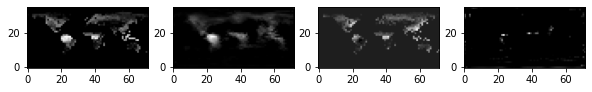


[0] - Finished evaluation - val_loss: 0.1595

[INFO] - Total time elapsed: 30.8722 min. Total time remaining: 7687.1717 min.

[EPOCH] ____________________1____________________
[1] - Finished Epoch in 51.33 seconds - train_loss: 0.1573


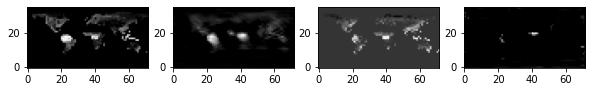


[1] - Finished evaluation - val_loss: 0.1567

[EPOCH] ____________________2____________________
[2] - Finished Epoch in 53.84 seconds - train_loss: 0.1553


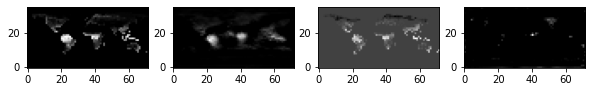


[2] - Finished evaluation - val_loss: 0.1555

[EPOCH] ____________________3____________________
[3] - Finished Epoch in 52.97 seconds - train_loss: 0.1534


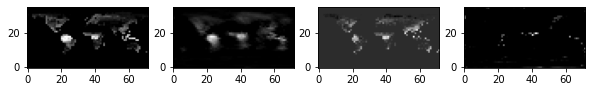


[3] - Finished evaluation - val_loss: 0.1571

[INFO] - Total time elapsed: 31.8011 min. Total time remaining: 1955.7679 min.

[EPOCH] ____________________4____________________
[4] - Finished Epoch in 52.26 seconds - train_loss: 0.1531


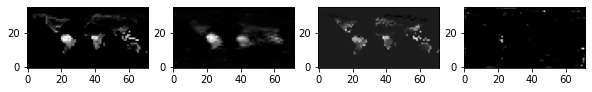


[4] - Finished evaluation - val_loss: 0.1535

[EPOCH] ____________________5____________________


In [ ]:
epochs = 250
for epoch in range(epochs):
    print(f'\n[EPOCH] ____________________{epoch}____________________')
    
    # training step with metrics update--------------------------------------------------------
    timer.start()

    train_step(model, train_ds, loss_function, optimizer, train_loss_metric, shape)

    # Evaluating training metrics
    train_loss = train_loss_metric.result()
    #train_acc = train_acc_metric.result()
    
    with train_summary_writer.as_default():     # logging our metrics to a file which is used by tensorboard
        tf.summary.scalar('loss', train_loss, step=epoch)
        #tf.summary.scalar('accuracy', train_acc, step=epoch)

    
    elapsed_time = timer.stop()
    
    print(f'[{epoch}] - Finished Epoch in {elapsed_time:0.2f} seconds - train_loss: {train_loss:0.4f}')
    
    # evaluation step with metrics update--------------------------------------------------------
    timer.start()

    eval_step(model, val_ds, loss_function, 
              loss_metric=val_loss_metric, 
             shape = shape)
    plt.show()
    # Evaluating validation metrics
    val_loss = val_loss_metric.result()
    #val_acc = val_acc_metric.result()
    
    with val_summary_writer.as_default():       # logging our metrics to a file which is used by tensorboard
        tf.summary.scalar('loss', val_loss, step=epoch)
        #tf.summary.scalar('accuracy', val_acc, step=epoch)
    
    print(f'\n[{epoch}] - Finished evaluation - val_loss: {val_loss:0.4f}')#, val_accuracy: {val_acc:0.4f}')
    
    # Resetting train and validation metrics-----------------------------------------------------
    #train_acc_metric.reset_states()
    #val_acc_metric.reset_states()
    train_loss_metric.reset_states()
    val_loss_metric.reset_states()
    
    elapsed_time = timer.stop()
    times.append(elapsed_time)
  
    if epoch%3 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(epochs-epoch-1)/60:0.4f} min.')

print(f'[INFO] - Total run time: {np.sum(times)/60:0.4f} min.')

In [45]:
for i,t in train_ds.take(1):
    a =model(i,training=False, shape = shape)

In [46]:
a = a.numpy()

In [64]:
np.median(a)

0.0002720684

In [56]:
t.numpy().min()

-2.1227619e-08

In [63]:
np.median(t.numpy())

0.0

In [24]:
tf.keras.backend.clear_session()